# Introduction


This project investigates whether a statistically robust framework can improve the harvesting of stablecoin spread dislocations in crypto markets.

Stablecoin-quoted pairs (e.g., asset/USDT vs asset/USDC) frequently exhibit small but persistent deviations driven by liquidity imbalances, funding pressures, collateral preferences, and market microstructure effects. While these spreads often mean-revert, they are also subject to regime shifts, structural repricing, and temporary shocks. A naive statistical approach may appear profitable in-sample but can fail once transaction costs, persistence effects, and structural breaks are properly accounted for.

The objective of this notebook is threefold:
- Design a robust signal construction framework capable of distinguishing temporary dislocations from structural shifts.
- Demonstrate the limitations of naive rolling statistics, particularly under changing regimes.
- Evaluate whether a state-space approach (Kalman Filter) improves decision-making and trading performance relative to simple rolling Z-score methods.

To achieve this, we:
- Compare rolling Z-score signals with Kalman-based adaptive signals.
- Introduce regime-awareness to differentiate structural drift from temporary noise.
- Run comparative backtests under realistic transaction cost assumptions.
- Analyze performance sensitivity to threshold selection and churn.

The broader research motivation is not merely to optimize a single pair, but to understand whether the observed stablecoin spread represents a systematic, harvestable risk premium - and if so, how it can be robustly extracted.

In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import empyrical as ep
from pykalman import KalmanFilter

import warnings
warnings.filterwarnings('ignore')

/Users/vkotopoulos/Dev/vkotopoulos/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



# 1. Data

For this research, I use 1-minute OHLCV data from Binance for the pairs BTC/USDT and BTC/USDC.

Ideally, the true mid-price should be derived from order book data:

    mid = (best_bid + best_ask) / 2

However, historical bookTicker data in Binance archive stops in 2024-03 (ref. [BTCUSDT](https://data.binance.vision/?prefix=data/futures/um/daily/bookTicker/BTCUSDT/) and [BTCUSDC](https://data.binance.vision/?prefix=data/futures/um/daily/bookTicker/BTCUSDC/))

Thus, to ensure this research is up-to-date, I construct a proxy mid-price using bar-level information.

The proxied mid-price is defined as:

    mid = (open + close) / 2

This approach assumes that the midpoint of the candle reasonably approximates the intrabar fair value. While not as precise as order book mid-prices, this proxy is appropriate for an initial framework design for spread analysis.

In [2]:
# Loading Binance 1-min OHLCV
usdt_ohlcv = pd.read_parquet('usdt_ohlcv.parquet')
usdc_ohlcv = pd.read_parquet('usdc_ohlcv.parquet')

In [3]:
# Aligning on common index
common_idx = usdt_ohlcv.index.intersection(usdc_ohlcv.index)
usdt_ohlcv = usdt_ohlcv.loc[common_idx]
usdc_ohlcv = usdc_ohlcv.loc[common_idx]

In [4]:
# Getting the proxied mid price
usdt_mid = (usdt_ohlcv.Open + usdt_ohlcv.Close) / 2
usdc_mid = (usdc_ohlcv.Open + usdc_ohlcv.Close) / 2

# 2. Spread Definition

The objective is to measure the relative pricing difference between BTC quoted in USDT and BTC quoted in USDC.

To ensure scale invariance and proper statistical treatment, the spread is defined in log-price space:

    spread = log(mid_usdt) - log(mid_usdc)

For interpretability, the spread is also scaled to basis points (bps) so that a value of +5 bps indicates BTC/USDT is trading approximately 0.05% richer than BTC/USDC at that timestamp.

In [5]:
# Computing the spread
spread = np.log(usdt_mid) - np.log(usdc_mid)

# Converting to an interpretable form (bps)
spread_bps = 1e4 * spread

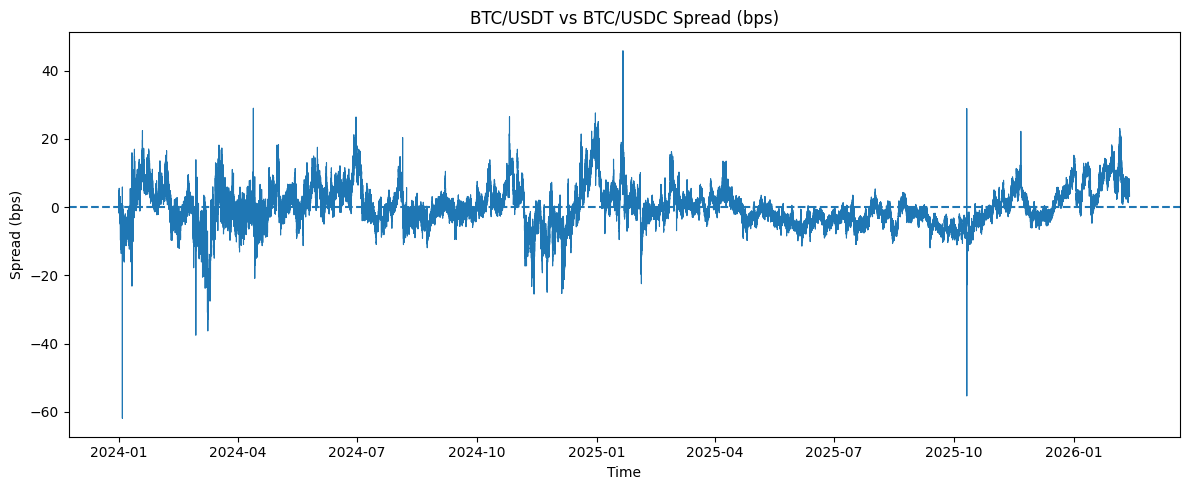

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(spread_bps, linewidth=0.8)
plt.axhline(0, linestyle="--")
plt.title("BTC/USDT vs BTC/USDC Spread (bps)")
plt.ylabel("Spread (bps)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


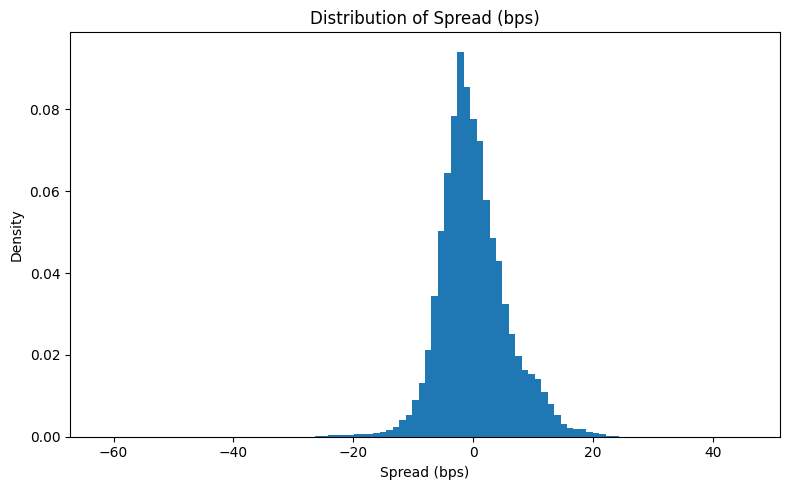

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(spread_bps, bins=100, density=True)
plt.title("Distribution of Spread (bps)")
plt.xlabel("Spread (bps)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [8]:
quantiles = spread_bps.quantile([0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999])

print("Tail Quantiles (bps):")
print(quantiles)

Tail Quantiles (bps):
0.001   -22.942337
0.010   -12.716594
0.050    -7.752733
0.500    -0.574344
0.950    10.534688
0.990    15.436513
0.999    21.026644
dtype: float64


In [9]:
print("\nSkewness:", spread_bps.skew())
print("Kurtosis:", spread_bps.kurt())



Skewness: 0.3351111798746454
Kurtosis: 1.5453841402495763


## Commentary

The raw BTC/USDT vs BTC/USDC spread exhibits several important empirical characteristics.

First, the spread is not perfectly centered at zero. The median is approximately –0.6 bps, indicating a small but persistent bias between the two stablecoin markets. While economically modest relative to intraday fluctuations, this suggests that the spread may reflect more than pure random noise and could contain a stablecoin-specific premium component.

Second, the distribution shows that most observations lie within approximately ±10 bps, but occasional large dislocations occur. The 1st and 99th percentiles are around –12.7 bps and +15.4 bps, respectively, and rare extreme events exceed ±20 bps, including a large negative outlier beyond –50 bps. These tail events are economically meaningful and significantly larger than typical minute-to-minute variations.

Third, the distribution exhibits moderate positive skew (≈ 0.33) and positive excess kurtosis (≈ 1.55). This indicates heavier tails than a Gaussian benchmark and asymmetry in extreme moves. In practical terms, extreme dislocations occur more frequently than a normal distribution would predict.

Overall, the spread displays:
- A small structural bias
- Occasional large shock-driven outliers
- Heavy-tailed behavior relative to normality

This combination - tight clustering most of the time with rare but sizable dislocations - suggests that simple rolling mean and standard deviation estimators may be sensitive to shocks and structural shifts. This motivates the need for a more adaptive and robust filtering framework in subsequent sections.

# 3. Stylized Facts (EDA)

## Distribution Characteristics

In [10]:
# Summary stats + tail quantiles
stats = pd.Series({
    "mean_bps": spread_bps.mean(),
    "median_bps": spread_bps.median(),
    "std_bps": spread_bps.std(),
    "skew": spread_bps.skew(),
    "excess_kurtosis": spread_bps.kurt(),
})

qs = spread_bps.quantile([0.01, 0.05, 0.50, 0.95, 0.99]).rename("quantiles_bps")

print("Summary stats:")
print(stats)

print("\nKey quantiles (bps):")
print(qs)


Summary stats:
mean_bps           0.067697
median_bps        -0.574344
std_bps            5.620113
skew               0.335111
excess_kurtosis    1.545384
dtype: float64

Key quantiles (bps):
0.01   -12.716594
0.05    -7.752733
0.50    -0.574344
0.95    10.534688
0.99    15.436513
Name: quantiles_bps, dtype: float64


## Mean Reversion Diagnostics

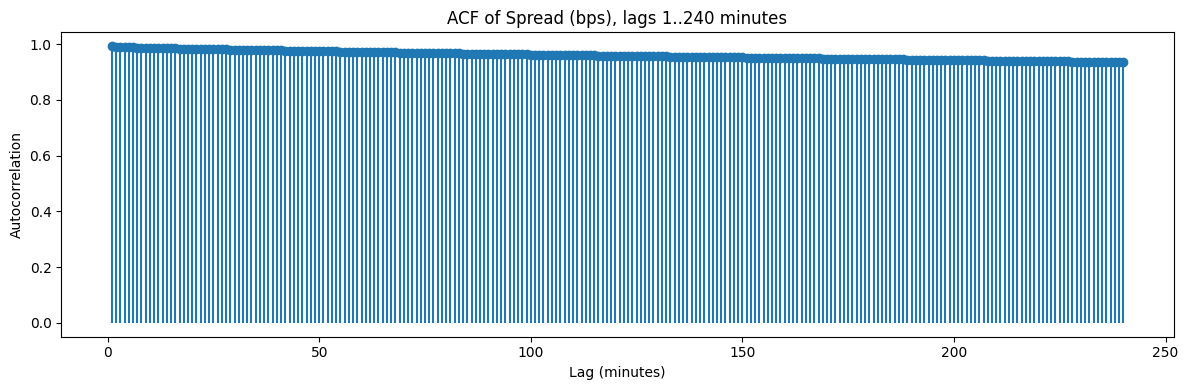

ACF(1), ACF(5), ACF(30), ACF(60):
  lag   1:  0.9930
  lag   5:  0.9891
  lag  30:  0.9808
  lag  60:  0.9725


In [11]:
# Autocorrelation (ACF)

max_lag = 240  # 4 hours
acf_vals = [spread_bps.autocorr(lag=i) for i in range(1, max_lag + 1)]

plt.figure(figsize=(12, 4))
plt.stem(range(1, max_lag + 1), acf_vals, basefmt=" ")
plt.title(f"ACF of Spread (bps), lags 1..{max_lag} minutes")
plt.xlabel("Lag (minutes)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

print("ACF(1), ACF(5), ACF(30), ACF(60):")
for lag in [1, 5, 30, 60]:
    print(f"  lag {lag:>3}: {spread_bps.autocorr(lag=lag): .4f}")


In [47]:
# Half-life estimate via AR(1) on levels: s_t = alpha + phi * s_{t-1} + eps

x = spread_bps.shift().dropna()
y = spread_bps.loc[x.index]

X = np.vstack([np.ones(len(x)), x.values]).T
alpha, phi = np.linalg.lstsq(X, y.values, rcond=None)[0]

if 0 < phi < 1:
    half_life_minutes = np.log(0.5) / np.log(phi)
else:
    half_life_minutes = np.nan

print(f"AR(1) fit: alpha={alpha:.4f}, phi={phi:.6f}")
print(f"Half-life (minutes): {half_life_minutes:.2f}")


AR(1) fit: alpha=0.0005, phi=0.993029
Half-life (minutes): 99.08


## Volatility Clustering / Stress Windows

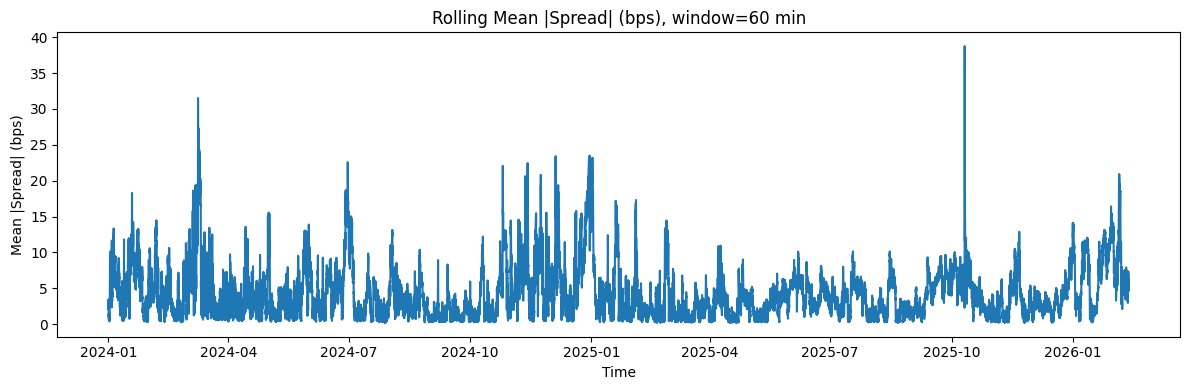

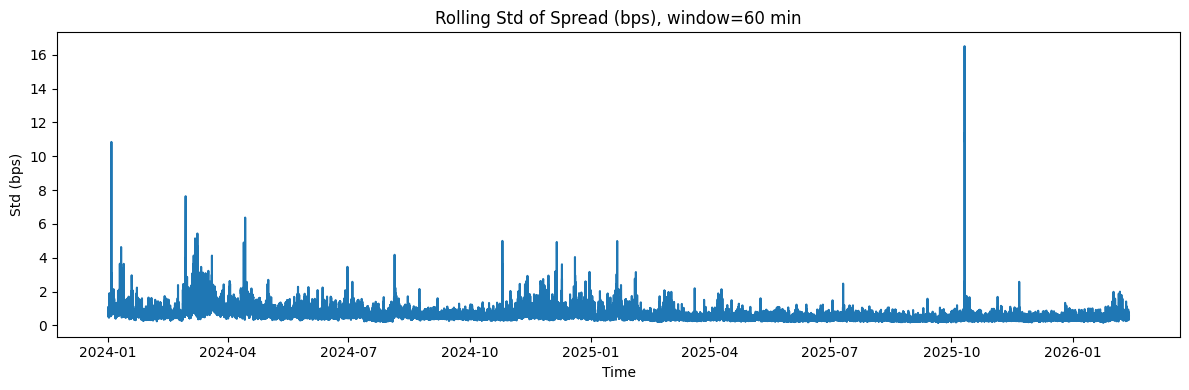

In [13]:
# Rolling Volatility Proxies

win = 60  # 1 hour 

roll_abs = spread_bps.abs().rolling(win).mean().shift()
roll_std = spread_bps.rolling(win).std().shift()

plt.figure(figsize=(12, 4))
plt.plot(roll_abs)
plt.title(f"Rolling Mean |Spread| (bps), window={win} min")
plt.xlabel("Time")
plt.ylabel("Mean |Spread| (bps)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(roll_std)
plt.title(f"Rolling Std of Spread (bps), window={win} min")
plt.xlabel("Time")
plt.ylabel("Std (bps)")
plt.tight_layout()
plt.show()


## Top K Shock Moments

In [14]:
# Identifying Top-K Shock Windows

K = 10
w = 60 

ds = spread_bps.diff().abs()

# Sort candidate timestamps by shock size
candidates = ds.dropna().sort_values(ascending=False)

selected = []
excluded_times = set()

for timestamp, value in candidates.items():
    if timestamp in excluded_times:
        continue

    # Select this event
    selected.append((timestamp, value))

    # Exclude w nearby minutes around this timestamp
    window = pd.date_range(
        start=timestamp - pd.Timedelta(minutes=w),
        end=timestamp + pd.Timedelta(minutes=w),
        freq="T"
    )
    excluded_times.update(window)

    if len(selected) >= K:
        break

top_jump_dedup = pd.DataFrame(selected, columns=["timestamp", "abs_dspread_bps"])
top_jump_dedup = top_jump_dedup.set_index("timestamp")

print("Top-K DISTINCT shock events (by |Δspread|):")
display(top_jump_dedup)

Top-K DISTINCT shock events (by |Δspread|):


,abs_dspread_bps
timestamp,
2024-01-03 12:12:00+00:00,42.385883
2025-01-20 17:06:00+00:00,42.158862
2024-01-10 20:11:00+00:00,39.064603
2025-10-10 21:18:00+00:00,32.616130
2024-02-28 17:27:00+00:00,22.833157
2024-04-12 18:35:00+00:00,21.787391
2024-04-13 19:56:00+00:00,18.419079
2024-08-05 01:13:00+00:00,16.650865
2024-01-09 21:11:00+00:00,13.542155


In [15]:
level_series = spread_bps.abs()
candidates_level = level_series.dropna().sort_values(ascending=False)

selected_level = []
excluded_times = set()

for timestamp, value in candidates_level.items():
    if timestamp in excluded_times:
        continue

    selected_level.append((timestamp, value))

    window = pd.date_range(
        start=timestamp - pd.Timedelta(minutes=w),
        end=timestamp + pd.Timedelta(minutes=w),
        freq="T"
    )
    excluded_times.update(window)

    if len(selected_level) >= K:
        break

top_level_dedup = pd.DataFrame(selected_level, columns=["timestamp", "abs_spread_bps"])
top_level_dedup = top_level_dedup.set_index("timestamp")

print("Top-K DISTINCT stress events (by |spread|):")
display(top_level_dedup)

Top-K DISTINCT stress events (by |spread|):


,abs_spread_bps
timestamp,
2024-01-03 12:11:00+00:00,61.872121
2025-10-10 22:37:00+00:00,55.325885
2025-01-20 17:05:00+00:00,45.806681
2024-02-28 17:26:00+00:00,37.532060
2024-03-08 21:57:00+00:00,36.277921
2025-10-10 21:19:00+00:00,31.766161
2024-03-08 15:28:00+00:00,30.847318
2024-03-08 20:43:00+00:00,29.704745
2024-03-09 02:44:00+00:00,29.602939


## Distinguishing Persistence from Mean Reversion

Φ at 0.993 suggests slow mean reversion, yet it's concerningly close to 1 (which suggests random walk). In the test below we're examining whether spread returns back to the mean after a shock event

In [16]:
horizons = [30, 60, 120, 240]
s = spread_bps.dropna()

# pick shock events by absolute jump 
ds = s.diff()
shock_idx = ds.abs().nlargest(500).index 

results = []
for h in horizons:
    future = s.shift(-h)
    delta = future.loc[shock_idx] - s.loc[shock_idx]

    # direction test: does it move back toward 0 (or toward pre-shock baseline)?
    # sign(s0)*delta should be negative if it mean reverts toward 0
    revert_score = np.sign(s.loc[shock_idx]) * delta

    results.append({
        "h_min": h,
        "mean_future_change": float(delta.mean()),
        "mean_revert_score": float(revert_score.mean()),
        "revert_hit_rate": float((revert_score < 0).mean()),
    })

pd.DataFrame(results)

,h_min,mean_future_change,mean_revert_score,revert_hit_rate
0,30,-0.967537,-3.060519,0.726
1,60,-1.318192,-3.195925,0.728
2,120,-0.306305,-3.963955,0.740
3,240,-0.116611,-4.339071,0.762


While the spread exhibits near-unit-root persistence in levels, large deviations display statistically significant directional reversion over 1–4 hour horizons. This suggests slow but economically meaningful mean-reversion dynamics rather than a pure random walk.

## Commentary

The spread exhibits several important dynamic properties that extend beyond its static distribution.

#### 1. Strong Persistence in Levels

The autocorrelation function reveals extremely high persistence in the spread. The first-lag autocorrelation is approximately 0.99, and remains above 0.97 even at a 60-minute horizon. This indicates that the spread evolves gradually rather than fluctuating randomly around a constant mean.

An AR(1) model estimated on the spread yields a persistence parameter of φ ≈ 0.993, corresponding to an implied half-life of approximately 99 minutes. In practical terms, following a shock, it takes roughly 1.5 hours for half of the deviation to decay under a simple linear mean-reversion assumption.
This behavior suggests slow adjustment dynamics rather than rapid microstructure-level mean reversion.

#### 2. Volatility Clustering

Rolling volatility estimates demonstrate clear regime variation. Extended periods of low dispersion (standard deviation near 1 bp) are punctuated by episodes of elevated volatility, during which dispersion temporarily increases to 5–15 bps or higher.
These elevated-volatility regimes persist for meaningful intervals before reverting to calmer conditions, indicating that shocks are not independently distributed over time. Instead, volatility exhibits clustering - a common stylized fact in financial time series.

#### 3. Episodic Shock Regimes

Distinct stress episodes are observable across the sample period. While most observations fall within a narrow intraday range, extreme events occur intermittently, with absolute spread levels exceeding 30–60 bps during major dislocations.

Importantly, large instantaneous jumps in the spread do not always coincide with the largest absolute spread levels. This distinction suggests the presence of both abrupt liquidity shocks and slower-moving structural adjustments in the underlying spread.

These shock episodes are concentrated in specific periods rather than uniformly distributed across time, indicating that tail risk is episodic and regime-dependent.

Taken together, the spread displays:
- Strong persistence in levels
- Slow mean-reversion dynamics
- Clear volatility clustering
- Episodic stress regimes

The combination of near-unit-root persistence and intermittent large shocks presents challenges for naive rolling estimators. A rolling mean implicitly assumes that the fair value is approximately constant within the estimation window, while rolling standard deviations assume stable dispersion. However, the empirical evidence suggests that the spread’s fair value evolves gradually over time and that volatility varies across regimes.
This motivates the use of adaptive filtering techniques capable of distinguishing between structural drift and temporary dislocations.

# 4. The Naive Approach: Rolling Z-Score (SMA)


## SMA Premium Estimates (1h, 8h, 1d)

In [ ]:
W = {
    "1h": 60,
    "8h": 60 * 8,
    "1d": 60 * 24,
}

sma_mean = {k: spread_bps.rolling(w).mean().shift() for k, w in W.items()}
sma_std  = {k: spread_bps.rolling(w).std().shift()  for k, w in W.items()}


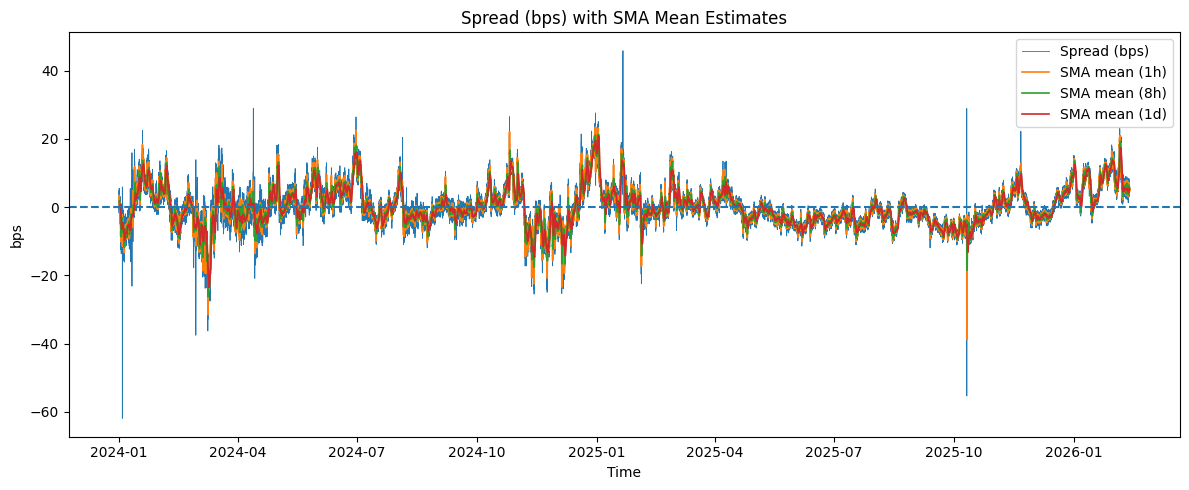

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(spread_bps, linewidth=0.6, label="Spread (bps)")
for k in ["1h", "8h", "1d"]:
    plt.plot(sma_mean[k], linewidth=1.2, label=f"SMA mean ({k})")
plt.axhline(0, linestyle="--")
plt.title("Spread (bps) with SMA Mean Estimates")
plt.xlabel("Time")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()


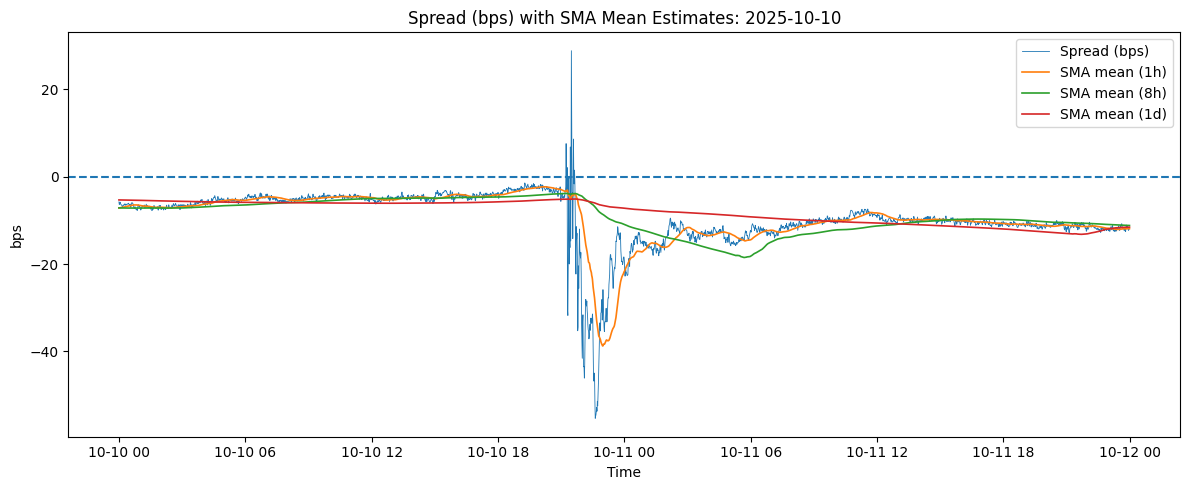

In [19]:
# Narrowing down to a major, known shock moment - 10/10

start = "2025-10-10"
end = "2025-10-11"

spread_sel = spread_bps.loc[start:end]
sma_mean_sel = {k: v.loc[start:end] for k, v in sma_mean.items()}

plt.figure(figsize=(12, 5))
plt.plot(spread_sel, linewidth=0.6, label="Spread (bps)")
for k in ["1h", "8h", "1d"]:
    plt.plot(sma_mean_sel[k], linewidth=1.2, label=f"SMA mean ({k})")
plt.axhline(0, linestyle="--")
plt.title("Spread (bps) with SMA Mean Estimates: 2025-10-10")
plt.xlabel("Time")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()


The overlay of the spread with 1-hour, 8-hour, and 1-day rolling means illustrates a core limitation of fixed-window estimators.

The estimated “fair value” depends mechanically on the chosen lookback length. Shorter windows respond more quickly to new information but introduce greater noise, while longer windows produce smoother estimates at the cost of substantial lag.

During large dislocations (e.g., 2025/10/10), the spread adjusts abruptly, whereas all rolling mean estimates adapt only gradually. The longer the window, the more pronounced the delay.

This reflects a structural limitation of rolling estimators: they implicitly assume that fair value is approximately constant within the lookback window and adjust only through mechanical averaging rather than through an explicit model of structural drift versus temporary shock.

## Window Sensitivity

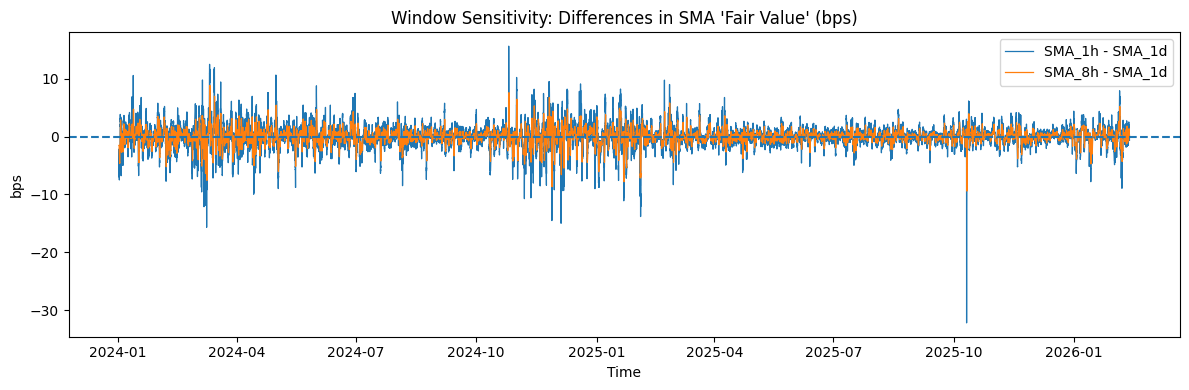

Window sensitivity summary (bps):


,SMA_1h - SMA_1d,SMA_8h - SMA_1d
count,1.112437e+06,1.112437e+06
mean,3.530346e-03,2.306840e-03
std,1.993483e+00,1.352162e+00
min,-3.218909e+01,-9.416537e+00
25%,-8.728756e-01,-5.926668e-01
50%,6.502335e-02,4.804209e-02
75%,9.573305e-01,6.622651e-01
max,1.562758e+01,8.838288e+00


In [20]:
# Differences between SMA means (fair value depends on window)
diff_1h_1d = sma_mean["1h"] - sma_mean["1d"]
diff_8h_1d = sma_mean["8h"] - sma_mean["1d"]

plt.figure(figsize=(12, 4))
plt.plot(diff_1h_1d, linewidth=0.9, label="SMA_1h - SMA_1d")
plt.plot(diff_8h_1d, linewidth=0.9, label="SMA_8h - SMA_1d")
plt.axhline(0, linestyle="--")
plt.title("Window Sensitivity: Differences in SMA 'Fair Value' (bps)")
plt.xlabel("Time")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()

print("Window sensitivity summary (bps):")
pd.DataFrame({
    "SMA_1h - SMA_1d": diff_1h_1d.describe(),
    "SMA_8h - SMA_1d": diff_8h_1d.describe()
})


The difference between SMA(1h) and SMA(1d) frequently reaches:
- ±2 bps
- Extremes above 8 bps

Given that the unconditional standard deviation of the spread is about 5.6 bps, this means that the estimated fair value itself can differ by roughly one standard deviation depending solely on window selection.

In other words: The naive approach does not provide a unique fair value estimate; it is parameter-dependent.

This is a structural weakness because trading signals derived from the spread will depend heavily on an arbitrary parameter choice.

## Naive Z-Score Instability

In [21]:
# Z-scores for each window
z_sma = {k: (spread_bps - sma_mean[k]) / sma_std[k] for k in W.keys()}

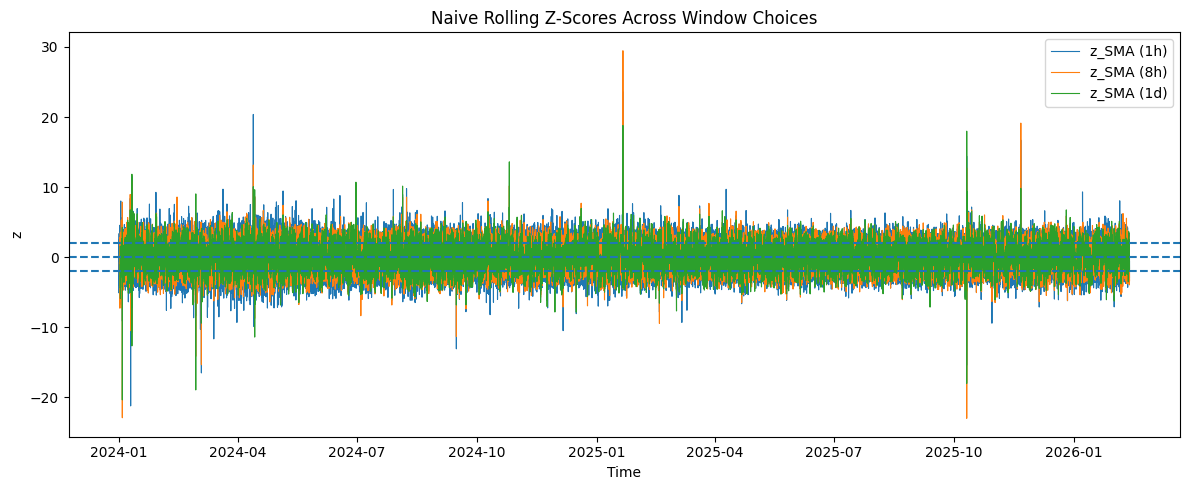

In [22]:
plt.figure(figsize=(12, 5))
for k in ["1h", "8h", "1d"]:
    plt.plot(z_sma[k], linewidth=0.8, label=f"z_SMA ({k})")
plt.axhline(0, linestyle="--")
plt.axhline(2, linestyle="--")
plt.axhline(-2, linestyle="--")
plt.title("Naive Rolling Z-Scores Across Window Choices")
plt.xlabel("Time")
plt.ylabel("z")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# Count threshold crossings (proxy for churn / turnover)
def count_crossings(z: pd.Series, thresh: float = 2.0) -> int:
    z = z.dropna()
    above = (z > thresh).astype(int)
    below = (z < -thresh).astype(int)
    # crossing events: when state flips 0->1
    cross_above = ((above.diff() == 1).sum())
    cross_below = ((below.diff() == 1).sum())
    return int(cross_above + cross_below)

cross_tbl = pd.DataFrame({
    "crossings_|z|>2": {k: count_crossings(z_sma[k], 2.0) for k in ["1h", "8h", "1d"]},
    "crossings_|z|>3": {k: count_crossings(z_sma[k], 3.0) for k in ["1h", "8h", "1d"]},
})

cross_tbl


,crossings_|z|>2,crossings_|z|>3
1h,62273,12219
8h,47074,9095
1d,36117,8151


The instability becomes more evident when examining rolling z-scores across window choices.

Shorter windows generate substantially more threshold crossings, leading to higher signal frequency and, by implication, greater turnover. Longer windows reduce moderate signal frequency but still produce extreme spikes during stress periods.

During shock events, z-scores can temporarily reach very large magnitudes because the rolling standard deviation - being backward-looking - has not yet adjusted to the new volatility regime. This creates artificial signal inflation immediately after dislocations.

These observations highlight two structural weaknesses of naive rolling z-scores:
- Signal instability across window choices.
- Volatility contamination following large shocks.

Both effects introduce sensitivity to arbitrary parameter selection and can materially affect trading behavior and transaction cost exposure.

## Lag Quantification

In [24]:
def top_k_shocks_dedup(series: pd.Series, k: int = 10, exclusion_min: int = 60) -> pd.DatetimeIndex:
    """
    Returns up to k shock timestamps (largest |Δseries|), de-duplicated by excluding
    the next `exclusion_min` minutes after selecting a shock.
    This avoids selecting overlapping minutes from the same shock episode.
    """
    ds = series.diff().abs().dropna().sort_values(ascending=False)

    picked = []
    blocked_until = None

    for t, v in ds.items():
        if blocked_until is not None and t <= blocked_until:
            continue
        picked.append(t)
        blocked_until = t + pd.Timedelta(minutes=exclusion_min)
        if len(picked) >= k:
            break

    return pd.DatetimeIndex(picked)

def lag_to_fraction_of_shock(
    series: pd.Series,
    mean_series: pd.Series,
    shock_t: pd.Timestamp,
    frac: float = 0.25,
    max_lookahead: int = 24 * 60
    ) -> float:
    """
    Measures minutes for mean_series to move by `frac` of the instantaneous shock magnitude
    (shock = series[t0] - series[t0-1]), relative to the pre-shock mean level mean_series[t0-1].

    Returns:
      - lag in minutes (float) if reached within max_lookahead
      - np.nan otherwise
    """
    if shock_t not in series.index or shock_t not in mean_series.index:
        return np.nan

    pos = series.index.get_loc(shock_t)
    if isinstance(pos, slice) or pos == 0:
        return np.nan

    t_prev = series.index[pos - 1]
    s_prev = series.loc[t_prev]
    s_t = series.loc[shock_t]
    m_prev = mean_series.loc[t_prev]

    if np.isnan(s_prev) or np.isnan(s_t) or np.isnan(m_prev):
        return np.nan

    shock = s_t - s_prev
    if shock == 0:
        return np.nan

    # Target: pre-shock mean + frac * shock
    target = m_prev + frac * shock
    direction = np.sign(shock)

    # Search forward in mean_series only
    fwd_idx = series.index[pos : pos + max_lookahead + 1]
    m_fwd = mean_series.loc[fwd_idx].dropna()
    if m_fwd.empty:
        return np.nan

    if direction > 0:
        hit = m_fwd[m_fwd >= target]
    else:
        hit = m_fwd[m_fwd <= target]

    if hit.empty:
        return np.nan

    t_hit = hit.index[0]
    return float((t_hit - shock_t) / pd.Timedelta(minutes=1))

def compute_lag_table(
    series: pd.Series,
    sma_mean: dict,
    shock_times: pd.DatetimeIndex,
    fracs=(0.25, 0.50),
    max_lookahead: int = 24 * 60
    ) -> pd.DataFrame:
    rows = []
    for t0 in shock_times:
        pos = series.index.get_loc(t0)
        if isinstance(pos, slice) or pos == 0:
            continue

        # instantaneous shock size in bps
        shock = float(series.iloc[pos] - series.iloc[pos - 1])

        row = {
            "shock_time": t0,
            "shock_dspread_bps": shock,
            "abs_shock_bps": abs(shock),
        }

        for frac in fracs:
            for kname in ["1h", "8h", "1d"]:
                row[f"lag_{int(frac*100)}pct_{kname}_min"] = lag_to_fraction_of_shock(
                    series, sma_mean[kname], t0, frac=frac, max_lookahead=max_lookahead
                )

        rows.append(row)

    out = pd.DataFrame(rows).sort_values("abs_shock_bps", ascending=False).reset_index(drop=True)
    return out

def plot_shock_episode(
    series: pd.Series,
    sma_mean: dict,
    t0: pd.Timestamp,
    hours_before: int = 12,
    hours_after: int = 24,
    ):
    start = t0 - pd.Timedelta(hours=hours_before)
    end   = t0 + pd.Timedelta(hours=hours_after)

    plt.figure(figsize=(12, 5))
    plt.plot(series.loc[start:end], linewidth=0.9, label="Spread (bps)")
    for k in ["1h", "8h", "1d"]:
        plt.plot(sma_mean[k].loc[start:end], linewidth=1.1, label=f"SMA mean ({k})")
    plt.axvline(t0, linestyle="--", label="Shock time")
    plt.axhline(0, linestyle=":", alpha=0.6)

    plt.title(f"Shock Episode Around {t0} (Spread + SMA Means)")
    plt.xlabel("Time")
    plt.ylabel("bps")
    plt.legend()
    plt.tight_layout()
    plt.show()

,shock_time,shock_dspread_bps,abs_shock_bps,lag_25pct_1h_min,lag_25pct_8h_min,lag_25pct_1d_min,lag_50pct_1h_min,lag_50pct_8h_min,lag_50pct_1d_min
0,2024-01-03 12:12:00+00:00,42.385883,42.385883,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-20 17:06:00+00:00,-42.158862,42.158862,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-10-10 21:18:00+00:00,-32.616130,32.616130,45.0,201.0,NaN,60.0,NaN,NaN
3,2025-11-21 07:33:00+00:00,6.553573,6.553573,22.0,NaN,NaN,NaN,NaN,NaN


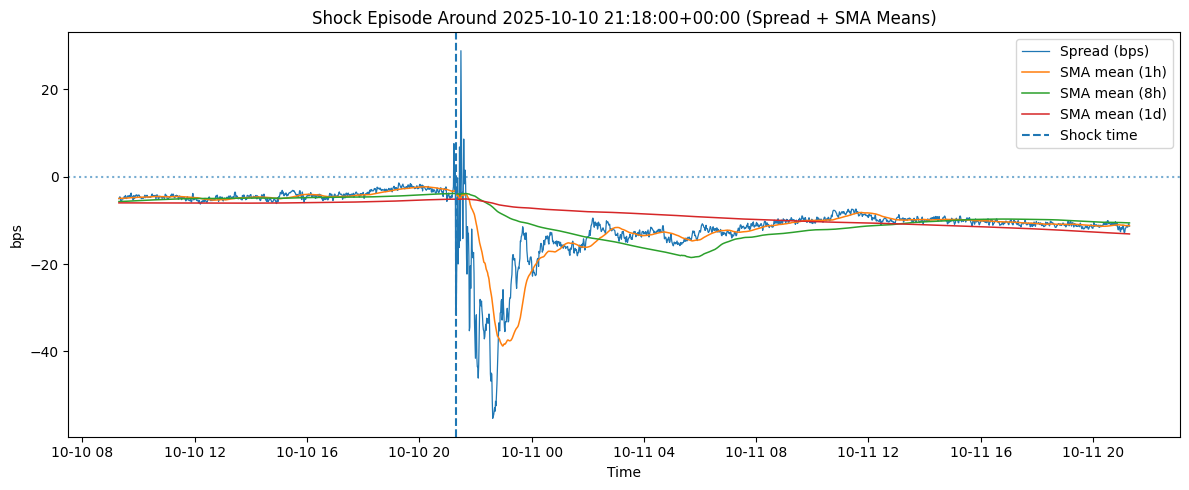

In [25]:
# ignore tiny shocks
MIN_ABS_SHOCK_BPS = 5.0

shock_times = top_k_shocks_dedup(spread_bps, k=10, exclusion_min=60)

# filter for meaningful shocks
shock_times = pd.DatetimeIndex([
    t for t in shock_times
    if abs(float(spread_bps.loc[t] - spread_bps.shift(1).loc[t])) >= MIN_ABS_SHOCK_BPS
])

# 1) lag table
lag_tbl = compute_lag_table(
    series=spread_bps,
    sma_mean=sma_mean,          
    shock_times=shock_times,
    fracs=(0.25, 0.50),
    max_lookahead=24*60
)

display(lag_tbl)

# Plot the shock episode on 2025-10-10
shock_episode_date = pd.Timestamp("2025-10-10", tz=spread_bps.index.tz)
closest_shock = lag_tbl.loc[lag_tbl["shock_time"].dt.strftime('%Y-%m-%d') == "2025-10-10", "shock_time"]
if not closest_shock.empty:
    t0 = closest_shock.iloc[0]
    plot_shock_episode(spread_bps, sma_mean, t0, hours_before=12, hours_after=24)

To quantify how quickly fixed-window rolling means react after large dislocations, we introduce a simple lag metric.
1. We identify “shock events” as the largest one-minute changes in the spread (de-duplicated so we don’t repeatedly select the same episode).
2. For each shock at time t, we measure how long it takes the rolling mean estimate to move by 25% and 50% of the instantaneous shock magnitude, relative to the pre-shock mean level.
3. If the rolling mean does not reach the threshold within 24 hours, the lag is reported as NaN (effectively “not reached on a trading horizon”).

The results highlight strong window-driven inertia. For example, during the 2025-10-10 shock, the 1-hour rolling mean reaches 25% adjustment in ~45 minutes and 50% in ~60 minutes, while the 8-hour and 1-day baselines often fail to reach comparable adjustment thresholds within 24 hours.

This demonstrates a key weakness of naive fixed-window estimators: responsiveness is mechanically governed by the window length. In several episodes, the spread begins reverting well before the longer-window mean has meaningfully adjusted, implying that the “fair value” estimate can remain stale throughout the relevant trading window.

In practice, this lag can:
- delay signal normalization after shocks,
- distort z-scores immediately after dislocations, and
- make trading behavior highly dependent on an arbitrary lookback choice.

This motivates using a more robust estimator that can adaptively separate temporary shocks from persistent drift, rather than blending them through mechanical averaging.

## Commentary

The rolling Z-score provides a simple and intuitive way to normalize the spread. However, when examined more carefully, it exhibits structural limitations that become important in the presence of shocks and regime shifts.

#### 1. Dependence on Window Length

The rolling estimator defines fair value as the average of the last N observations. This assumes the spread is locally stable within that window.

Different window lengths lead to different:
- Mean estimates
- Volatility estimates
- Signal magnitudes

Short windows react quickly but are noisy.
Long windows are smoother but slower to adjust.

There is no single window that works best across all market conditions. The trade-off between responsiveness and stability is fixed by design.

#### 2. Mechanical Lag After Shocks

When a large shock occurs, the rolling mean adjusts gradually because each new data point only receives a fixed weight of 1/N.

This creates a predictable lag. The estimator cannot tell whether the move is:
- A temporary deviation
- A structural shift

It simply averages forward.
As a result, signals may remain distorted for some time after major dislocations.

#### 3. Volatility Adjustment Effects

Rolling volatility is fully backward-looking.

After a shock:
- Z-scores may initially spike because volatility has not yet increased.
- As the large observation enters the window, volatility rises.
- Signals may then compress even if the spread remains elevated.

This can lead to inconsistent signal strength across time.

#### 4. No Explicit Modeling of Equilibrium

Most importantly, the rolling approach does not model equilibrium as a latent state. It produces a smoothed average, but it does not provide:
- A dynamic estimate of fair value
- A measure of confidence
- A way to distinguish structural drift from noise

In environments where spreads experience both temporary shocks and gradual shifts, this limitation becomes meaningful.

#### Summary

The rolling Z-score is simple and transparent, but its behavior is entirely governed by the chosen window length. Its responsiveness and stability cannot adapt to changing regimes.
These limitations motivate the move toward a state-space approach, where fair value evolves dynamically rather than being defined by a fixed historical window.

# 5. Robust Alternative: State-Space Model (Kalman Filter)

## Model Specification and Comparison with Naive Method

The Kalman Filter is a state-space estimation method that treats the “true” fair value of the spread as a latent variable that evolves over time. Instead of computing a rolling average over a fixed window, it continuously updates its estimate of equilibrium by balancing two forces: how noisy current observations are, and how much the underlying fair value is allowed to drift. This makes it a dynamic alternative to fixed-window smoothing.

The model is governed by two hyperparameters: R and Q.

R represents measurement noise - in this context, the short-term variability of the spread driven by liquidity effects and microstructure noise. 

Q represents state noise - how much the underlying equilibrium is allowed to move from one period to the next. Intuitively, R controls how much we trust new observations, while Q controls how flexible the estimated fair value is.

To calibrate these parameters in an interpretable way, we anchor them to an economically meaningful quantity: the half-life of mean reversion. R is estimated from the typical short-horizon variability of the spread, while Q is derived from R using an assumed half-life. A shorter half-life implies faster adjustment and therefore a larger Q; a longer half-life implies a more stable equilibrium and a smaller Q. This allows the filter’s responsiveness to be controlled by a single, interpretable time-scale parameter.

Because half-life can itself vary across time, using a single full-sample estimate may introduce selection bias. To mitigate this, half-life is estimated across multiple contiguous sub-samples. 

In [ ]:
def ar1_halflife_minutes_levels(spread_bps: pd.Series) -> float:
    s = spread_bps.dropna().astype(float)
    x = s.shift(1).dropna()
    y = s.loc[x.index]

    X = np.vstack([np.ones(len(x)), x.values]).T
    alpha, phi = np.linalg.lstsq(X, y.values, rcond=None)[0]

    if 0 < phi < 1:
        return float(np.log(0.5) / np.log(phi))
    return np.nan

def chunk_halflives_levels(spread_bps: pd.Series, n_chunks: int = 8):
    s = spread_bps.dropna().astype(float)
    n = len(s)
    chunk_size = n // n_chunks

    rows = []
    for i in range(n_chunks):
        seg = s.iloc[i*chunk_size : (i+1)*chunk_size] if i < n_chunks-1 else s.iloc[i*chunk_size:]
        hl = ar1_halflife_minutes_levels(seg)
        rows.append({
            "chunk": i+1,
            "start": seg.index[0],
            "end": seg.index[-1],
            "half_life_minutes": hl
        })

    out = pd.DataFrame(rows)
    summary = {
        "mean": float(np.nanmean(out["half_life_minutes"])),
        "std": float(np.nanstd(out["half_life_minutes"])),
        "min": float(np.nanmin(out["half_life_minutes"])),
        "max": float(np.nanmax(out["half_life_minutes"])),
    }
    return out, summary

In [49]:
chunks, summary = chunk_halflives_levels(spread_bps, n_chunks=8)
display(chunks)
print(summary)

,chunk,start,end,half_life_minutes
0,1,2023-12-31 23:00:00+00:00,2024-04-06 15:33:00+00:00,50.575547
1,2,2024-04-06 15:34:00+00:00,2024-07-12 08:07:00+00:00,38.949138
2,3,2024-07-12 08:08:00+00:00,2024-10-17 00:41:00+00:00,36.812089
3,4,2024-10-17 00:42:00+00:00,2025-01-21 17:15:00+00:00,230.932828
4,5,2025-01-21 17:16:00+00:00,2025-04-28 09:49:00+00:00,79.413913
5,6,2025-04-28 09:50:00+00:00,2025-08-03 02:23:00+00:00,61.761006
6,7,2025-08-03 02:24:00+00:00,2025-11-07 18:57:00+00:00,95.117224
7,8,2025-11-07 18:58:00+00:00,2026-02-12 11:36:00+00:00,235.574713


{'mean': 103.6420573899183, 'std': 77.04733692058367, 'min': 36.81208869524431, 'max': 235.57471295951646}


The resulting range (approximately 37 to 236 minutes) indicates regime-dependent persistence. However, the full-sample estimate (~99 minutes) lies close to the sub-sample average and therefore serves as a representative baseline calibration. This approach ensures the chosen time scale reflects the central tendency of the data rather than any single regime.

Measurement noise is defined conservatively using an economically meaningful deviation threshold anchored to transaction costs. In our backtesting setup, we assume 2 basis points per transaction. Deviations smaller than this magnitude are unlikely to be economically exploitable once fees and execution frictions are considered. Relying solely on raw minute-to-minute variance would capture microstructure jitter at sub-actionable magnitudes, causing the filter to react to noise that cannot be traded profitably. We therefore impose a minimum economically relevant noise scale of 2 basis points, yielding R=2^2. This ensures that fluctuations smaller than estimated transaction costs are treated as noise rather than signal, reducing spurious threshold crossings and aligning model sensitivity with economic reality.

Given this effective noise level and the representative half-life of 99 minutes, Q is derived from the same time-scale mapping and further scaled conservatively to prevent the latent fair value from tracking microstructure noise too aggressively. The resulting specification balances responsiveness with turnover control while preserving the structural interpretation of the model.

In a production setting, Q and R would be estimated more rigorously - for example via rolling or expanding window calibration, or by allowing Q to vary across detected regimes. The present specification is intentionally transparent and economically grounded, serving as a baseline implementation that isolates the structural advantages of state-space modeling over fixed rolling estimators without introducing unnecessary parameter complexity.

In [128]:
sigma_min = 2.0  # economically meaningful deviation in bps
R = sigma_min**2

half_life = 99 # minutes
Q = R * (1 / half_life) * 0.5  # conservative drift

In [129]:
y = spread_bps.values

kf = KalmanFilter(
    transition_matrices=[1.0],
    observation_matrices=[1.0],
    initial_state_mean=y[0],
    initial_state_covariance=1.0,
    observation_covariance=R,
    transition_covariance=Q
)

state_means, state_covs = kf.filter(y)

kalman_mean = pd.Series(state_means.flatten(), index=spread_bps.index, name="kalman_mean")
P = pd.Series([c[0, 0] for c in state_covs], index=spread_bps.index, name="state_var")

kalman_std_dynamic = np.sqrt(P + R)
kalman_std_dynamic.name = "kalman_std_dynamic"

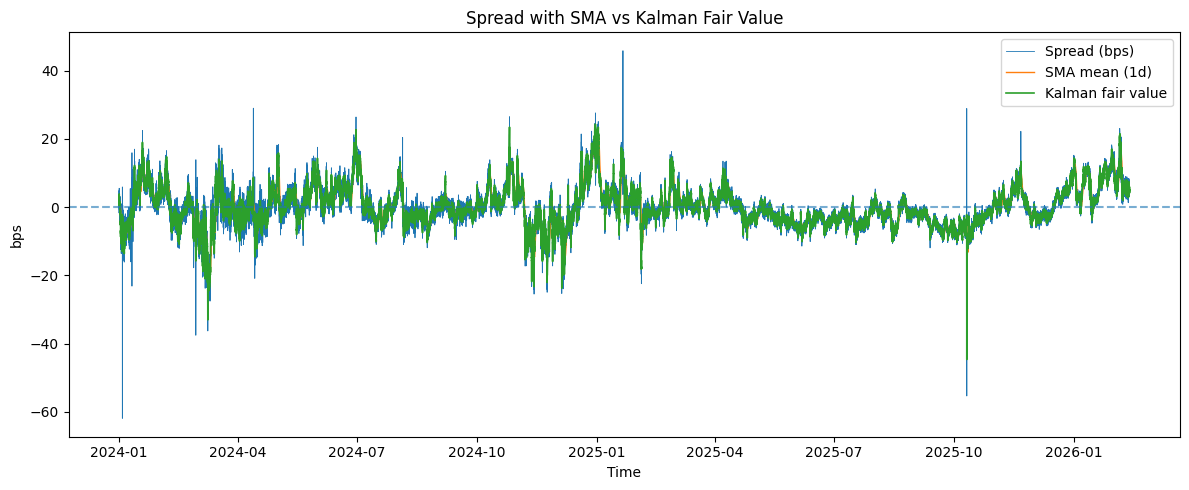

In [130]:
plt.figure(figsize=(12, 5))
plt.plot(spread_bps, linewidth=0.6, label="Spread (bps)")
plt.plot(sma_mean["1d"].loc[s.index], linewidth=1.0, label="SMA mean (1d)")
plt.plot(kalman_mean, linewidth=1.2, label="Kalman fair value")
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Spread with SMA vs Kalman Fair Value")
plt.xlabel("Time")
plt.ylabel("bps")
plt.legend()
plt.tight_layout()
plt.show()

## Kalman-based Z-Score

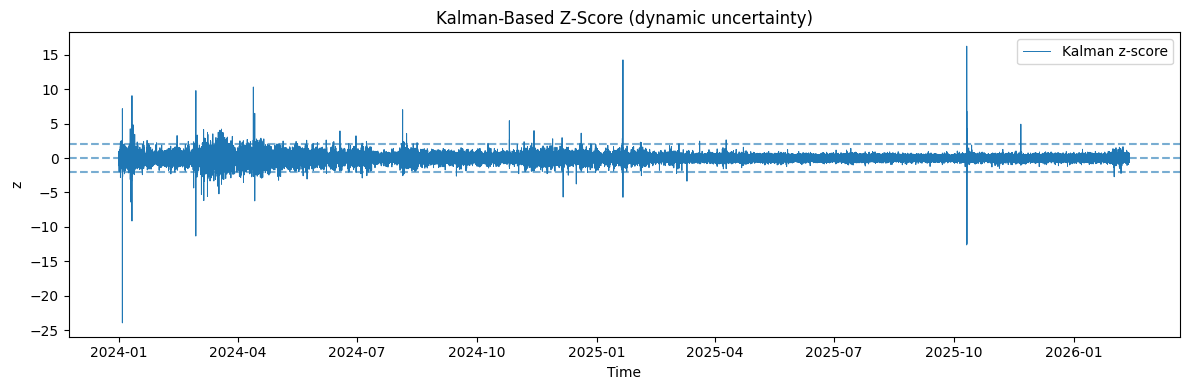

count    1.113877e+06
mean     1.102761e-05
std      3.042902e-01
min     -2.395987e+01
25%     -1.551053e-01
50%     -5.155129e-04
75%      1.546444e-01
max      1.627229e+01
Name: z_kalman, dtype: float64


In [131]:
# Kalman-based z-score using dynamic volatility estimate
z_kalman = (spread_bps - kalman_mean) / kalman_std_dynamic
z_kalman.name = "z_kalman"

plt.figure(figsize=(12, 4))
plt.plot(z_kalman, linewidth=0.7, label="Kalman z-score")
plt.axhline(0, linestyle="--", alpha=0.6)
plt.axhline(2, linestyle="--", alpha=0.6)
plt.axhline(-2, linestyle="--", alpha=0.6)
plt.title("Kalman-Based Z-Score (dynamic uncertainty)")
plt.xlabel("Time")
plt.ylabel("z")
plt.legend()
plt.tight_layout()
plt.show()

print(z_kalman.describe())

## Threshold-crossing churn comparison (SMA vs Kalman)

In [132]:
def count_crossings(z: pd.Series, thresh: float = 2.0) -> int:
    z = z.dropna()
    above = (z > thresh).astype(int)
    below = (z < -thresh).astype(int)
    cross_above = (above.diff() == 1).sum()
    cross_below = (below.diff() == 1).sum()
    return int(cross_above + cross_below)

# Define rolling windows and estimator names
W = {"SMA_1h": 60, "SMA_8h": 60*8, "SMA_1d": 60*24}

# Compute z-scores for SMA estimators
z_sma = {k: (spread_bps - sma_mean[k.split("_")[1]]) / sma_std[k.split("_")[1]] for k in W.keys()}

# Build table rows for each estimator
cross_data = []
for name, z in z_sma.items():
    cross_data.append({
        "estimator": name,
        "cross_|z|>2": count_crossings(z, 2.0),
        "cross_|z|>3": count_crossings(z, 3.0),
    })
# Add Kalman estimator
cross_data.append({
    "estimator": "Kalman",
    "cross_|z|>2": count_crossings(z_kalman, 2.0),
    "cross_|z|>3": count_crossings(z_kalman, 3.0),
})

cross_tbl = pd.DataFrame(cross_data).set_index("estimator")
cross_tbl

,cross_|z|>2,cross_|z|>3
estimator,,
SMA_1h,62273,12219
SMA_8h,47074,9095
SMA_1d,36117,8151
Kalman,588,111


## Shock Responsiveness: Time-to-Adjustment Analysis

To formally quantify estimator responsiveness, we introduce a lag metric: time-to-α-adjustment following a large spread shock.

For each major one-minute dislocation, we measure how long it takes for the fair value estimate to incorporate 25% and 50% of the shock magnitude.

This directly tests how quickly different estimators adapt to structural changes.

In [133]:
def top_k_shocks_dedup(series: pd.Series, k: int = 10, exclusion_min: int = 60) -> pd.DatetimeIndex:
    ds = series.diff().abs().dropna().sort_values(ascending=False)
    picked = []
    blocked_until = None

    for t, v in ds.items():
        if blocked_until is not None and t <= blocked_until:
            continue
        picked.append(t)
        blocked_until = t + pd.Timedelta(minutes=exclusion_min)
        if len(picked) >= k:
            break

    return pd.DatetimeIndex(picked)

shock_times = top_k_shocks_dedup(spread_bps, k=8, exclusion_min=60)

In [134]:
def lag_to_fraction_of_shock(
    series: pd.Series,
    est: pd.Series,
    shock_t: pd.Timestamp,
    frac: float = 0.50,
    max_lookahead: int = 24 * 60,
    ) -> float:
    """
    Shock = series[t0] - series[t0-1]
    Target = est[t0-1] + frac * Shock
    Lag = minutes until est reaches target (in the shock direction)
    """
    series = series.dropna()
    est = est.dropna()

    if shock_t not in series.index or shock_t not in est.index:
        return np.nan

    pos = series.index.get_loc(shock_t)
    if isinstance(pos, slice) or pos == 0:
        return np.nan

    t_prev = series.index[pos - 1]
    if t_prev not in est.index:
        return np.nan

    shock = float(series.iloc[pos] - series.iloc[pos - 1])
    if shock == 0:
        return np.nan

    est_prev = float(est.loc[t_prev])
    target = est_prev + frac * shock
    direction = np.sign(shock)

    # Search forward
    fwd_idx = series.index[pos : pos + max_lookahead + 1]
    est_fwd = est.reindex(fwd_idx).dropna()
    if est_fwd.empty:
        return np.nan

    if direction > 0:
        hit = est_fwd[est_fwd >= target]
    else:
        hit = est_fwd[est_fwd <= target]

    if hit.empty:
        return np.nan

    t_hit = hit.index[0]
    return float((t_hit - shock_t) / pd.Timedelta(minutes=1))

In [135]:
estimators = {
    "SMA_1h": sma_mean["1h"].loc[s.index],
    "SMA_8h": sma_mean["8h"].loc[s.index],
    "SMA_1d": sma_mean["1d"].loc[s.index],
    "Kalman": kalman_mean.loc[s.index],
}

rows = []
for t0 in shock_times:
    pos = spread_bps.index.get_loc(t0)
    shock = float(s.iloc[pos] - spread_bps.iloc[pos - 1])

    row = {"shock_time": t0, "shock_dspread_bps": shock, "abs_shock_bps": abs(shock)}
    for name, est in estimators.items():
        row[f"lag25_{name}_min"] = lag_to_fraction_of_shock(spread_bps, est, t0, frac=0.25, max_lookahead=24*60)
        row[f"lag50_{name}_min"] = lag_to_fraction_of_shock(spread_bps, est, t0, frac=0.50, max_lookahead=24*60)
    rows.append(row)

lag_tbl = pd.DataFrame(rows).sort_values("abs_shock_bps", ascending=False).reset_index(drop=True)

display(lag_tbl)
print("Note : A NaN lag indicates that the estimator did not reach the target adjustment within the 24-hour lookahead window.")

,shock_time,shock_dspread_bps,abs_shock_bps,lag25_SMA_1h_min,lag50_SMA_1h_min,lag25_SMA_8h_min,lag50_SMA_8h_min,lag25_SMA_1d_min,lag50_SMA_1d_min,lag25_Kalman_min,lag50_Kalman_min
0,2024-01-03 12:12:00+00:00,42.385883,42.385883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-20 17:06:00+00:00,-42.158862,42.158862,NaN,NaN,NaN,NaN,NaN,NaN,1421.0,NaN
2,2025-10-10 21:18:00+00:00,-32.616130,32.616130,45.0,60.0,201.0,NaN,NaN,NaN,30.0,42.0
3,2025-11-21 07:33:00+00:00,6.553573,6.553573,22.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN
4,2026-01-31 18:43:00+00:00,-4.622083,4.622083,24.0,50.0,200.0,367.0,463.0,845.0,4.0,15.0
5,2026-02-06 00:27:00+00:00,4.586710,4.586710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2026-02-06 03:32:00+00:00,-2.945784,2.945784,617.0,637.0,37.0,74.0,139.0,282.0,606.0,637.0
7,2026-02-06 11:49:00+00:00,2.417161,2.417161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note : A NaN lag indicates that the estimator did not reach the target adjustment within the 24-hour lookahead window.


In [136]:
lag_summary = lag_tbl.filter(like="lag50").describe().round(2)
lag_summary

,lag50_SMA_1h_min,lag50_SMA_8h_min,lag50_SMA_1d_min,lag50_Kalman_min
count,3.00,2.00,2.00,3.00
mean,249.00,220.50,563.50,231.33
std,336.06,207.18,398.10,351.58
min,50.00,74.00,282.00,15.00
25%,55.00,147.25,422.75,28.50
50%,60.00,220.50,563.50,42.00
75%,348.50,293.75,704.25,339.50
max,637.00,367.00,845.00,637.00


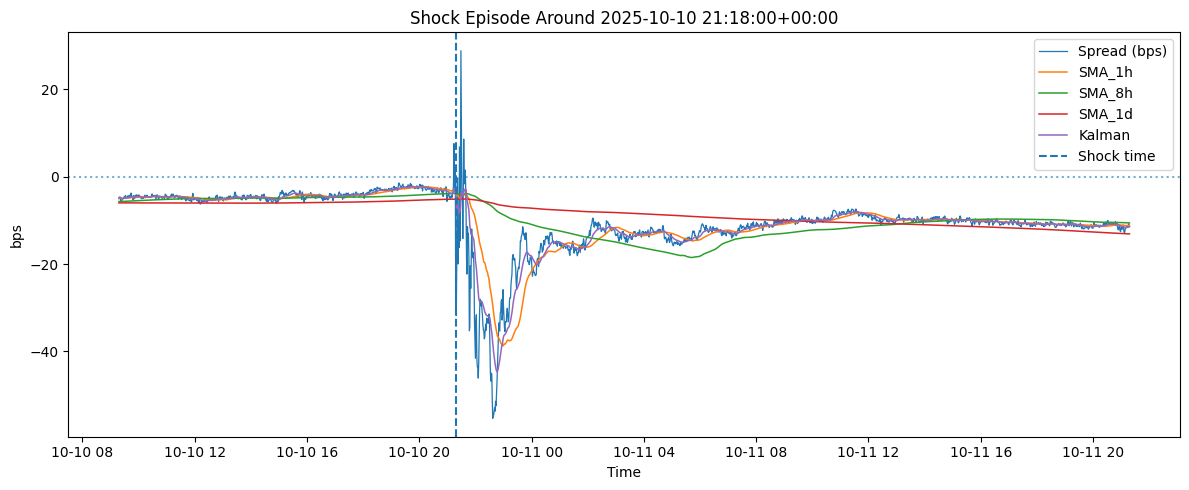

In [137]:
def plot_shock_episode(series: pd.Series, ests: dict, t0: pd.Timestamp, hours_before=12, hours_after=24):
    start = t0 - pd.Timedelta(hours=hours_before)
    end = t0 + pd.Timedelta(hours=hours_after)

    plt.figure(figsize=(12, 5))
    plt.plot(series.loc[start:end], linewidth=0.9, label="Spread (bps)")
    for name, est in ests.items():
        plt.plot(est.loc[start:end], linewidth=1.1, label=name)
    plt.axvline(t0, linestyle="--", label="Shock time")
    plt.axhline(0, linestyle=":", alpha=0.6)
    plt.title(f"Shock Episode Around {t0}")
    plt.xlabel("Time")
    plt.ylabel("bps")
    plt.legend()
    plt.tight_layout()
    plt.show()

example_day = "2025-10-10"
candidates = lag_tbl[lag_tbl["shock_time"].dt.strftime("%Y-%m-%d") == example_day]
if not candidates.empty:
    t0 = candidates.iloc[0]["shock_time"]
else:
    t0 = lag_tbl.iloc[0]["shock_time"]

plot_shock_episode(spread_bps, estimators, t0, hours_before=12, hours_after=24)

The lag analysis quantifies how quickly each estimator incorporates large one-minute spread shocks into its fair value estimate.

Median 50% adjustment times increase monotonically with SMA window length:
- SMA(1h): ~60 minutes
- SMA(8h): ~220 minutes
- SMA(1d): ~563 minutes

This confirms that rolling estimators adjust mechanically according to their lookback horizon.

The Kalman filter exhibits a lower median 50% adjustment time (~42 minutes), indicating faster typical responsiveness. Importantly, its adaptation speed is not fixed ex ante by a window parameter but emerges endogenously from the state covariance update.

Long-window SMAs frequently fail to reach 50% adjustment within the 24-hour lookahead window, resulting in undefined lags. This reflects effective regime inertia: the estimator continues to reflect outdated information long after the shock.

From a trading perspective, slow adjustment:
- Delays signal normalization
- Distorts z-scores during volatility transitions
- Introduces parameter-dependent regime lag

Overall, the results provide quantitative evidence that fixed-window rolling averages exhibit mechanical, parameter-driven inertia, while the state-space estimator adapts more flexibly to large structural shocks.

## Regime Detection: Structural vs Temporary

Residual summary:
count    1.113877e+06
mean     2.253967e-05
std      6.291062e-01
min     -4.953581e+01
25%     -3.206723e-01
50%     -1.065797e-03
75%      3.197193e-01
max      3.364214e+01
Name: residual, dtype: float64

Drift(6h) summary:
count    1.113517e+06
mean     1.011826e-03
std      2.104459e+00
min     -3.980104e+01
25%     -8.836665e-01
50%      3.278372e-02
75%      9.696249e-01
max      3.193977e+01
Name: drift_6h, dtype: float64


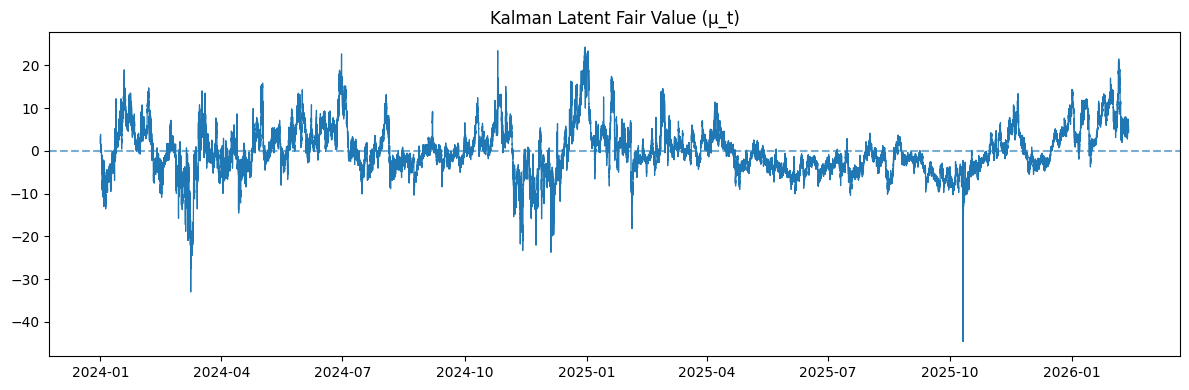

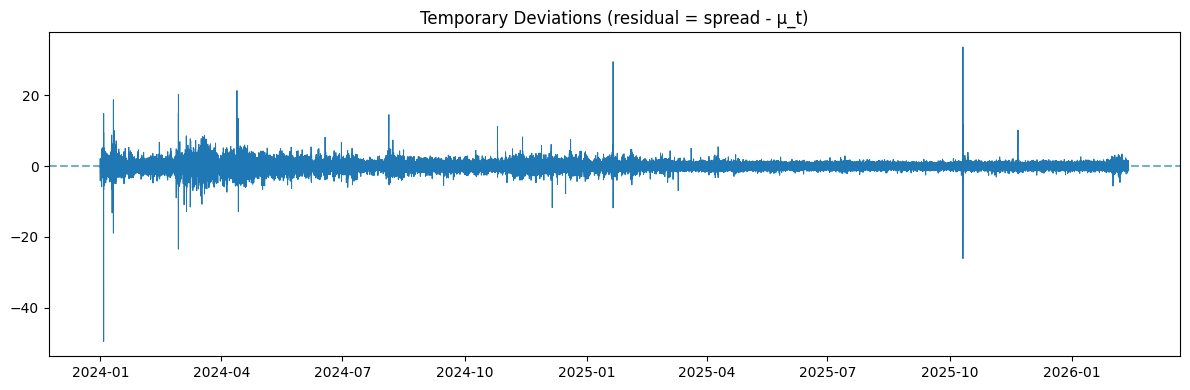

In [138]:
residual = (spread_bps - kalman_mean).rename("residual")

# Structural drift proxy: change in fair value over 6 hours
drift = kalman_mean.diff(360).rename("drift_6h")

print("Residual summary:")
print(residual.describe())

print("\nDrift(6h) summary:")
print(drift.describe())

plt.figure(figsize=(12, 4))
plt.plot(kalman_mean, linewidth=0.9)
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Kalman Latent Fair Value (μ_t)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(residual, linewidth=0.7)
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Temporary Deviations (residual = spread - μ_t)")
plt.tight_layout()
plt.show()

Structural minutes flagged: 40232
Temporary shock minutes flagged: 680


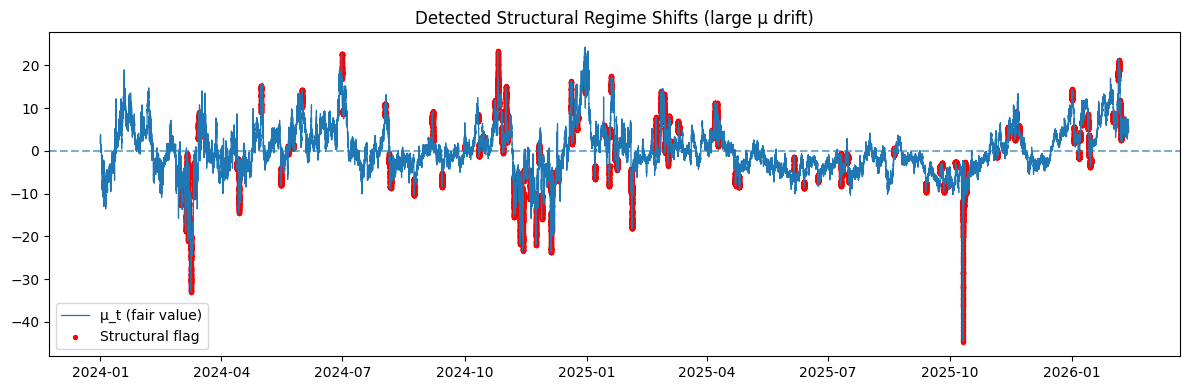

In [139]:
# Scale is estimated robustly using a rolling MAD window set to ~100× the drift horizon (~25 days, rounded to 30), 
# ensuring enough observations for stability while still adapting across volatility regimes.

W = 30*24*60 # 30 days 

drift_med = drift.rolling(W).median().shift()
drift_mad = (drift - drift_med).abs().rolling(W).median().shift()
drift_scale = 1.4826 * drift_mad + 1e-8
drift_z = drift / drift_scale

structural_flag = drift_z.abs() > 4

# Adding a persistence filter
Y = 180   # last 3 hours
X = 10    # at least 10 flagged minutes
structural_flag = structural_flag.rolling(Y).sum().shift() >= X

temporary_flag = (residual.abs() > 2 * kalman_std_dynamic) & (~structural_flag)

print("Structural minutes flagged:", int(structural_flag.sum()))
print("Temporary shock minutes flagged:", int(temporary_flag.sum()))

plt.figure(figsize=(12, 4))
plt.plot(kalman_mean, linewidth=0.9, label="μ_t (fair value)")
plt.scatter(kalman_mean[structural_flag].index, kalman_mean[structural_flag], s=8, label="Structural flag", color='red')
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Detected Structural Regime Shifts (large μ drift)")
plt.legend()
plt.tight_layout()
plt.show()

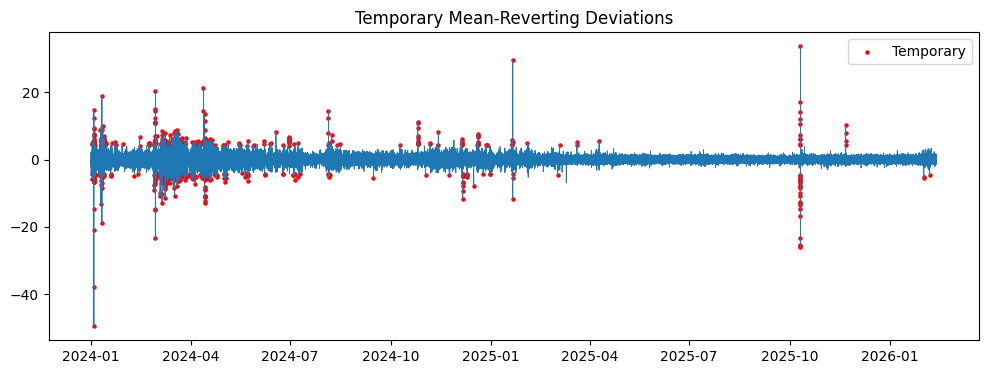

In [140]:
plt.figure(figsize=(12,4))
plt.plot(residual, linewidth=0.6)
plt.scatter(residual[temporary_flag].index,
            residual[temporary_flag],
            s=5, color="red", label="Temporary")
plt.title("Temporary Mean-Reverting Deviations")
plt.legend()
plt.show()

In [141]:
structural_runs = structural_flag.astype(int).groupby(
    (structural_flag != structural_flag.shift()).cumsum()
).sum()

structural_runs = structural_runs[structural_runs > 0]

print("Structural %:", round(structural_flag.mean()*100, 3))
print("Temporary %:", round(temporary_flag.mean()*100, 3))
print("Number of structural regimes:", len(structural_runs))
print("Median structural duration (min):", int(structural_runs.median()))

Structural %: 3.612
Temporary %: 0.061
Number of structural regimes: 132
Median structural duration (min): 248


## Commentary

The rolling mean approach implicitly assumes that the spread oscillates around a fixed local average. In practice, however, the spread exhibits both short-lived dislocations and sustained fair-value relocations. A simple SMA cannot distinguish between the two: it treats structural repricing as temporary deviation, leading to premature mean-reversion trades during regime shifts.

To address this, I model the spread using a state-space framework where the observed spread is decomposed into:
- A latent fair value component μ
- A residual noise component ϵ

The Kalman filter provides a dynamic estimate of the latent fair value μ, updating in real time as new data arrives. This allows the model to separate:
- Structural shifts → persistent changes in μ
- Temporary dislocations → large residual deviations from μ

Structural regimes are defined as statistically significant and persistent movements in the latent fair value (measured via a 6-hour drift normalized by a rolling robust scale). Temporary regimes are defined as extreme residual deviations not accompanied by fair-value relocation.

Empirically:
- Structural regimes occur ~3–4% of the time and persist for several hours.
- Temporary dislocations are rare (<0.1%) and correspond to sharp but short-lived deviations.

This separation is economically meaningful:
- Structural shifts represent repricing of stablecoin basis conditions.
- Temporary shocks reflect liquidity imbalances or short-term microstructure effects.

By explicitly distinguishing between these two regimes, the model avoids the key failure of naive rolling averages: trading aggressively against a moving fair value. This framework therefore enables regime-aware trading rules that adapt signal aggressiveness depending on whether the market is undergoing structural repricing or transient dislocation.

# Signal Generation & Comparative Backtesting

In this section, we construct trading signals for three alternative methodologies, which are subsequently evaluated in the Comparative Backtesting section.

The three signal specifications are:
- Naive approach (fixed rolling Z-score)
- Kalman filter without regime awareness
- Kalman filter with structural regime detection

To assess parameter sensitivity, we evaluate two entry/exit configurations based on Z-score thresholds: 2/0 and 3/0 (entry at ±2σ or ±3σ, exit at mean reversion).

Transaction costs are modeled at 2 basis points per transaction, consistent with a trading account below $15 million in 30-day volume and maker fee tiers. This assumption is intentionally conservative. In practice, simultaneous execution across both legs may incur filling delays and slippage, particularly in fast markets. However, due to the absence of detailed order book data, we adopt a flat 2bps cost framework to approximate trading friction while maintaining methodological simplicity.

## Naive Signals

In [142]:
def get_naive_signals(ENTRY_Z, EXIT_Z):

    # Using a 1-day lookback as a reasonable intraday equilibrium proxy that captures a full liquidity cycle, 
    # serving as a non-optimized fixed-memory benchmark against the adaptive Kalman model.
    w = 60 * 24 

    ma = spread_bps.rolling(60*24).mean().shift()
    std = spread_bps.rolling(60*24).std().shift()

    z = (spread_bps - ma) / std

    # Entry signals 
    long_entries = (z < -ENTRY_Z)
    short_entries = (z > ENTRY_Z)

    # Exit signals
    long_exits = (z > EXIT_Z)
    short_exits = (z < EXIT_Z)

    # Ensure boolean dtype, aligned index
    long_entries_naive, short_entries_naive, long_exits_naive, short_exits_naive = [
        s.fillna(False).astype(bool) for s in (long_entries, short_entries, long_exits, short_exits)
    ]

    return long_entries_naive, short_entries_naive, long_exits_naive, short_exits_naive

## Kalman-based Signals w/o Regime Awareness

In [143]:
def get_kalman_signals(ENTRY_Z, EXIT_Z):

    z = z_kalman.copy()

    # Entry signals 
    long_entries = (z < -ENTRY_Z)
    short_entries = (z > ENTRY_Z)

    # Exit signals
    long_exits = (z > EXIT_Z)
    short_exits = (z < EXIT_Z)

    # Ensure boolean dtype, aligned index
    long_entries_kalman, short_entries_kalman, long_exits_kalman, short_exits_kalman = [
        s.fillna(False).astype(bool) for s in (long_entries, short_entries, long_exits, short_exits)
    ]

    return long_entries_kalman, short_entries_kalman, long_exits_kalman, short_exits_kalman

## Kalman-based Signals with Regime Awareness

In [144]:
def get_kalman_reg_signals(ENTRY_Z, EXIT_Z):

    z = z_kalman.copy()

    # Regime filter - trade only temporary dislocations
    struct = structural_flag.reindex(z.index).fillna(False).astype(bool)
    temp = temporary_flag.reindex(z.index).fillna(False).astype(bool)
    trade_ok = (~struct) & temp

    # Base entries/exits from z-crosses
    base_long_entries = (z < -ENTRY_Z)
    base_short_entries = (z > ENTRY_Z)

    base_long_exits = (z > EXIT_Z)
    base_short_exits = (z < EXIT_Z)

    # Gate entries; exits include forced risk-off on structural onset
    struct_onset = struct & (~struct.shift().fillna(False))

    long_entries = base_long_entries & trade_ok
    short_entries = base_short_entries & trade_ok

    long_exits = base_long_exits | struct_onset
    short_exits = base_short_exits | struct_onset

    long_entries_kalman_reg, short_entries_kalman_reg, long_exits_kalman_reg, short_exits_kalman_reg = [
        s.fillna(False).astype(bool) for s in (long_entries, short_entries, long_exits, short_exits)
    ]

    return long_entries_kalman_reg, short_entries_kalman_reg, long_exits_kalman_reg, short_exits_kalman_reg

## Backtesting

In [145]:
signal_sets_entry_2 = {
    'naive': (
        get_naive_signals(2, 0)
    ),
    'kalman': (
        get_kalman_signals(2, 0)
    ),
    'kalman_reg': (
        get_kalman_reg_signals(2, 0)
    ),
}

signal_sets_entry_3 = {
    'naive': (
        get_naive_signals(3, 0)
    ),
    'kalman': (
        get_kalman_signals(3, 0)
    ),
    'kalman_reg': (
        get_kalman_reg_signals(3, 0)
    ),
}

In [146]:
def run_bt(signal_sets: dict[str, tuple[pd.Series, pd.Series, pd.Series, pd.Series]], fees=0.0001) -> tuple[pd.DataFrame, pd.DataFrame]:

    rets_dict = {}
    stats_dict = {}

    for sig_name, (le, se, lx, sx) in signal_sets.items():

        leg1 = vbt.Portfolio.from_signals(
            close=usdt_mid,
            entries=le.loc[usdt_mid.index],
            exits=lx.loc[usdt_mid.index],
            short_entries=se.loc[usdt_mid.index],
            short_exits=sx.loc[usdt_mid.index],
            fees=fees
        )

        leg2 = vbt.Portfolio.from_signals(
            close=usdc_mid.loc[usdt_mid.index],
            entries=se.loc[usdt_mid.index],
            exits=sx.loc[usdt_mid.index],
            short_entries=le.loc[usdt_mid.index],
            short_exits=lx.loc[usdt_mid.index],
            fees=fees
        )

        rets = pd.concat([leg1.returns(), leg2.returns()], axis=1).mean(axis=1)

        trades = leg1.trades.records_readable
        trades['Duration'] = (trades['Exit Timestamp'] - trades['Entry Timestamp']).dt.total_seconds() / 60

        rets_dict[f"{sig_name}_rets"] = rets
        stats_dict[f"{sig_name}_stats"] = {
            "cagr": ep.cagr(rets, annualization=365*24*60) * 100,
            "sharpe": ep.sharpe_ratio(rets, annualization=365*24*60),
            "sortino": ep.sortino_ratio(rets, annualization=365*24*60),
            "maxdd": ep.max_drawdown(rets) * 100,
            "calmar": ep.calmar_ratio(rets, annualization=365*24*60),
            "total_ret": ep.cum_returns_final(rets) * 100,
            "trades": len(trades),
            "avg_holding_time_in_mins": trades.Duration.mean()
        }

    return pd.DataFrame(rets_dict), pd.DataFrame(stats_dict)

In [147]:
rets0bps_2, stats0bps_2 = run_bt(signal_sets_entry_2, 0.0000) 
rets2bps_2, stats2bps_2 = run_bt(signal_sets_entry_2, 0.0002) 

rets0bps_3, stats0bps_3 = run_bt(signal_sets_entry_3, 0.0000) 
rets2bps_3, stats2bps_3 = run_bt(signal_sets_entry_3, 0.0002) 


## Results

In [150]:
print('ENTRY THRESHOLD : 2')
print('------------------------------------------------------------')
print('Stats without Fees')
print(stats0bps_2)
print('------------------------------------------------------------')
print()
print('Stats with 2bp Fees')
print(stats2bps_2)

ENTRY THRESHOLD : 2
------------------------------------------------------------
Stats without Fees
                          naive_stats  kalman_stats  kalman_reg_stats
cagr                        45.618187      7.585707          7.361120
sharpe                      20.819707     11.153545         11.083335
sortino                     32.045424     27.080229         28.001117
maxdd                       -1.839604     -0.225240         -0.225240
calmar                      24.797834     33.678304         32.681204
total_ret                  121.765741     16.760472         16.244531
trades                    6497.000000    519.000000        487.000000
avg_holding_time_in_mins    77.032784      5.680154          4.963039
------------------------------------------------------------

Stats with 2bp Fees
                          naive_stats  kalman_stats  kalman_reg_stats
cagr                       -57.277813     -2.453229         -2.066887
sharpe                     -38.567970     -3.986

In [151]:
print('ENTRY THRESHOLD : 3')
print('------------------------------------------------------------')
print('Stats without Fees')
print(stats0bps_3)
print('------------------------------------------------------------')
print()
print('Stats with 2bp Fees')
print(stats2bps_3)

ENTRY THRESHOLD : 3
------------------------------------------------------------
Stats without Fees
                          naive_stats  kalman_stats  kalman_reg_stats
cagr                        14.986299      2.342154          2.344300
sharpe                       9.868137      4.575646          4.686287
sortino                     15.126691     10.244555         10.941396
maxdd                       -1.562531     -0.225240         -0.225240
calmar                       9.591039     10.398472         10.408003
total_ret                   34.438652      5.028725          5.033394
trades                    1768.000000     97.000000         89.000000
avg_holding_time_in_mins   158.608032      5.855670          4.707865
------------------------------------------------------------

Stats with 2bp Fees
                          naive_stats  kalman_stats  kalman_reg_stats
cagr                       -17.638060      0.485947          0.639891
sharpe                     -12.584295      1.058

## Commentary

This section evaluates three signal construction approaches: a fixed-window rolling Z-score (naive), an adaptive Kalman-based Z-score, and a regime-aware Kalman specification incorporating structural drift detection.

Gross of transaction costs, the naive rolling strategy delivers exceptionally high Sharpe ratios. However, this apparent performance is driven by very high trade frequency and aggressive turnover. Once realistic transaction costs are applied, the strategy deteriorates sharply, generating negative returns and large drawdowns. This highlights a key weakness of fixed-window mean reversion: it systematically over-trades small, transient fluctuations and confuses microstructure noise for economically exploitable dislocations.

In contrast, the Kalman-based approaches operate with substantially lower turnover. By adaptively estimating a time-varying equilibrium and scaling deviations according to model-implied uncertainty, they reduce noise sensitivity and limit marginal trades. Importantly, both Kalman variants remain economically viable under realistic fee assumptions, with the regime-aware specification achieving the strongest risk-adjusted performance and superior drawdown control.

The threshold sensitivity analysis further strengthens this conclusion. While the naive strategy proves highly unstable to modest parameter changes (from 3σ to 2σ), the Kalman-based signals exhibit far greater stability, indicating structural robustness rather than parameter-dependent performance.

Overall, the findings demonstrate that fixed rolling estimators are economically fragile in the presence of transaction costs, whereas adaptive state-space modeling materially improves signal quality. Regime awareness further enhances capital efficiency by limiting exposure during structural shifts. While statistical mean reversion is present in the spread, its economic viability depends critically on adaptive equilibrium estimation and structural regime identification.

# Conclusion

This study demonstrates that signal construction methodology materially impacts trading behavior and realized performance.

While the naive rolling Z-score framework appears attractive gross of costs, it suffers from:
- Implicit fixed-window assumptions,
- Sensitivity to structural shifts,
- Elevated turnover and transaction cost drag.

The Kalman-based approach introduces adaptive estimation of the spread’s latent state, allowing the model to respond dynamically to evolving conditions. Incorporating regime awareness further improves interpretability by separating structural repricing from temporary dislocations.

However, even with improved signal construction, transaction costs meaningfully erode performance. This highlights a crucial insight: microstructure edges require disciplined filtering, turnover control, and cross-sectional scaling to remain economically viable.

The core takeaway is that robustness - not raw signal strength - determines implementability.

# Next Steps

The natural extension of this research is to move from a single-pair strategy to a cross-sectional portfolio framework designed to systematically harvest the stablecoin spread risk premium.

Planned next steps include:

#### 1. Cross-Sectional Expansion

- Construct spreads across multiple assets (e.g., BTC, ETH, SOL, and broader top-market-cap tokens).
- Avoid survivorship bias by dynamically updating the universe.
- Standardize spread measures across assets for comparability.

#### 2. Factor Construction

- Aggregate spread signals into a stablecoin basis factor.
- Construct long/short baskets based on cross-sectional Z-scores.
- Evaluate whether the premium is systematic rather than idiosyncratic.

#### 3. Portfolio Optimization

- Apply risk budgeting and capital allocation rules.
- Control for turnover and liquidity constraints.
- Introduce volatility scaling or signal-strength weighting.

The ultimate goal is to determine whether the stablecoin spread represents a persistent, scalable risk premium that can be harvested through diversified portfolio construction rather than isolated pair trades.
If validated, this would shift the strategy from a micro alpha signal to a systematic factor exposure.
